Notebook per fare il Training e il Testing del modello per la classe di centralità 10-40 % per fare il confronto con i risultati dell'analisi standard. Nella prima parte del notebook Training e Testing, nella seconda viene stimata la Significance che si otterrebbe misurando lo yield. 

In [2]:
%pylab inline
import uproot
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pickle
from scipy.stats import norm
from scipy import stats
%run ../Utils/analysis_utils.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
training = True

# Uproot Conversion

In [3]:
df_event=uproot.open('../../../HypertritonAnalysis/Trees/HyperTritonTree_18r.root')['_custom']['fTreeV0'].pandas.df('fCent')

In [6]:
df_event2=uproot.open('../../../HypertritonAnalysis/Trees/HyperTritonTree_18q.root')['_custom']['fTreeV0'].pandas.df('fCent')

In [8]:
Nev_0_10_1=len(df_event.query('fCent<10'))

In [7]:
Nev_0_10_2=len(df_event2.query('fCent<10'))

In [9]:
Nev_0_10=Nev_0_10_2+Nev_0_10_1

In [10]:
Nev_0_10

93302191

In [11]:
df_MC = uproot.open('../../../HypertritonAnalysis/Derived_Trees/SignalTable.root')['SignalTable'].pandas.df()

In [12]:
df_data = uproot.open('../../../HypertritonAnalysis/Derived_Trees/DataTable.root')['DataTable'].pandas.df()

### Calculate pre selection efficiency

In [13]:
cuts_presel='ProngsDCA<1.6 and He3ProngPvDCA>0.01 and He3ProngPvDCA>0.01 and V0CosPA>0.98 and Centrality<10'

In [3]:
eff_v0=np.load('../PreSelEfficiency/eff_V0_0_10.npy')

In [5]:
eff_23=eff_v0[0]*len(df_MC.query(cuts_presel+' and 2<V0pt<3'))/len(df_MC.query('2<V0pt<3 and Centrality<10'))

NameError: name 'df_MC' is not defined

In [16]:
eff_34=eff_v0[1]*len(df_MC.query(cuts_presel+' and 3<V0pt<4'))/len(df_MC.query('3<V0pt<4 and Centrality<10'))

In [17]:
eff_45=eff_v0[2]*len(df_MC.query(cuts_presel+' and 4<V0pt<5'))/len(df_MC.query('4<V0pt<5 and Centrality<10'))

In [18]:
eff_59=eff_v0[3]*len(df_MC.query(cuts_presel+' and 5<V0pt<9'))/len(df_MC.query('5<V0pt<9 and Centrality<10'))

In [19]:
eff_presel=[eff_23,eff_34,eff_45,eff_59]

### Create ML dataframes

In [20]:
df_18r=df_data.query('Centrality<10 and 2.960<InvMass<3.050 and V0pt<=10')
df_18r = df_18r.astype('float')

In [21]:
sig=df_MC.query(cuts_presel)

In [22]:
bkg = df_data.query('(InvMass<2.98 or InvMass>3.005) and V0pt<=10 and Centrality<10 ')


In [23]:
bkg['y']=0
df_MC['y']=1
df= pd.concat([df_MC,bkg])

/home/fmazzasc/.local_pip/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
del(df_event)
del(df_event2)
del(df_MC)
del(df_data)
del(sig)
del(bkg)

# Data preliminary

Carico i dati, defisco le variabili su cui fare Training e preparo il Training Set.

In [25]:
training_columns = [ 'V0CosPA','ProngsDCA', 'DistOverP','ArmenterosAlpha','NpidClustersHe3','V0pt','TPCnSigmaHe3']

In [26]:
traindata,testdata,ytrain,ytest = train_test_split(df, df['y'], test_size=0.5)

Plotto le variabili di Training del segnale e del fondo come confronto e la matrice delle correlazioni.

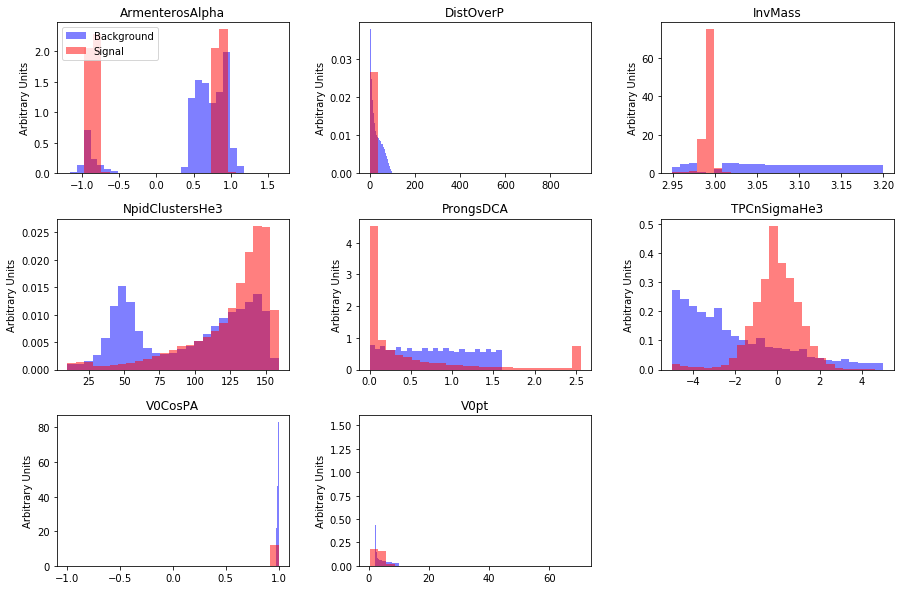

In [27]:
plot_distr(df,training_columns+['InvMass'])

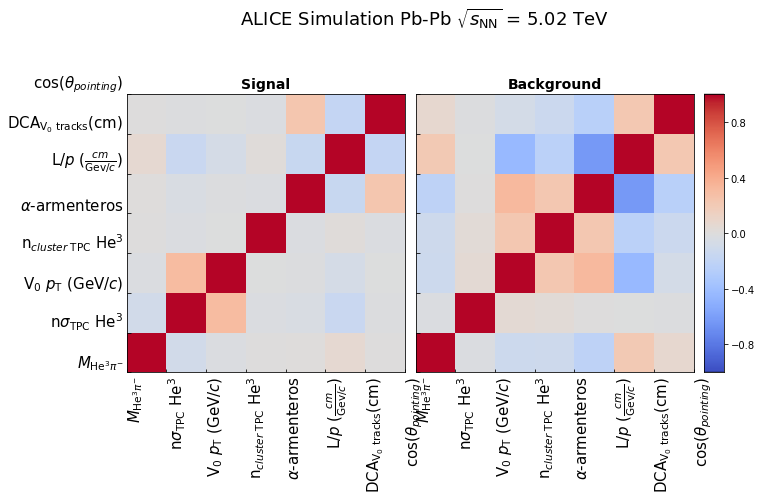

In [28]:
plot_corr(df,training_columns)

# Training

For using pre-trained models skip to the Testing part.

In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)
scoring = 'auc'
early_stopping_rounds = 20
num_rounds = 200
params_def = {
    # Parameters that we are going to tune.
    'max_depth':8,
    'eta':0.05,
    'gamma':0.7,
    'min_child_weight':8,
    'subsample':0.8,
    'colsample_bytree':0.9,
    'objective':'binary:logistic',
    'random_state':42,
    'silent':1,
    'nthread':4,
    'tree_method':'hist',
    'scale_pos_weight': 10}


In [30]:
dtrain = xgb.DMatrix(data=np.asarray(traindata[training_columns]), label=ytrain, feature_names=training_columns)
#n_round = optimize_params(dtrain,params_def)
model_cent_integr = xgb.train(params_def, dtrain,num_boost_round=num_rounds) 

/home/fmazzasc/.local_pip/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [31]:
# saving the model
pickle.dump(model_cent_integr,open("../Models/model_0_10.pkl", "wb"))

# Testing

If you skip the Training start from here.

In [32]:
if training:
    model = model_cent_integr
else:
    model = pickle.load(open("../Models/model_0_10.pkl", "rb"))

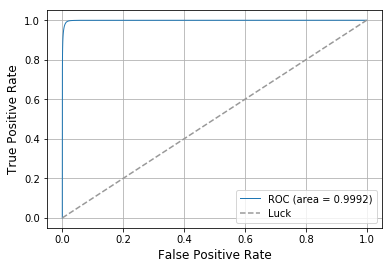

In [33]:
dtest = xgb.DMatrix(data=testdata[training_columns])
y_pred = model.predict(dtest,output_margin=True)
plot_roc(ytest,y_pred)

Ks_2sampResult(statistic=0.9775095986460651, pvalue=0.0)


(1e-05, 1)

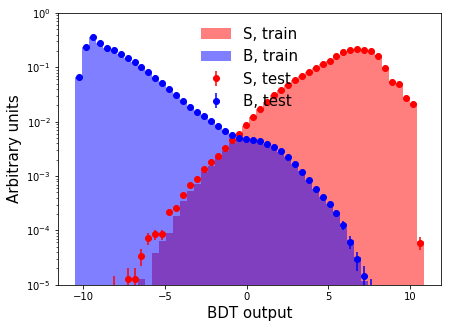

In [34]:
plot_output_train_test(model, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True,log=True,location=9)
plt.ylim([10**-5,10**0])

Ks_2sampResult(statistic=0.9775095986460651, pvalue=0.0)


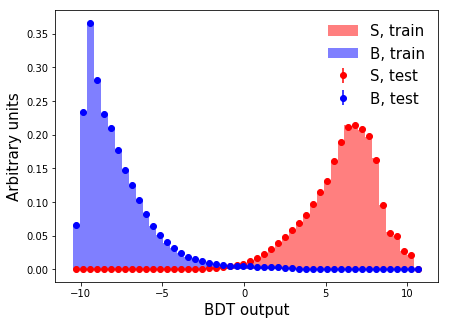

In [35]:
plot_output_train_test(model, traindata[training_columns], ytrain, testdata[training_columns], ytest, branch_names=training_columns,raw=True)

# BDT Efficiency 

Calcolo l'efficienza del modello in funzione dello Score.

<Figure size 432x288 with 0 Axes>

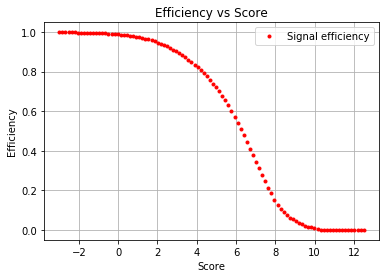

<Figure size 432x288 with 0 Axes>

In [53]:
testdata.eval('Score = @y_pred',inplace=True)
efficiency_array=EfficiencyVsCuts(testdata)
plt.figure() 

# Significance Scan Vs pT

Scan della Significance Vs BDT Score negli stessi bin di pT in cui Stefano ha estratto lo yield doppio differenziale per confrontare la massima sign. ottenibile con il BDT con la sign. ottenuta con il metodo standard. Eventi in classe di centralità 10-40%.


In [54]:
%run ../Utils/Significance_Test.py

<Figure size 432x288 with 0 Axes>

/home/fmazzasc/HypertritonML/2body/Utils/Significance_Test.py:28: RuntimeWarning: divide by zero encountered in double_scalars
  err_1=(np.sqrt(sig+bkg)-sig*(1/(2*np.sqrt(sig+bkg))))/(sig+bkg)
/home/fmazzasc/HypertritonML/2body/Utils/Significance_Test.py:28: RuntimeWarning: invalid value encountered in double_scalars
  err_1=(np.sqrt(sig+bkg)-sig*(1/(2*np.sqrt(sig+bkg))))/(sig+bkg)
/home/fmazzasc/HypertritonML/2body/Utils/Significance_Test.py:29: RuntimeWarning: invalid value encountered in double_scalars
  err_2=sig/(2*(sig+bkg)**(3/2))
/home/fmazzasc/.local_pip/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


<Figure size 432x288 with 0 Axes>

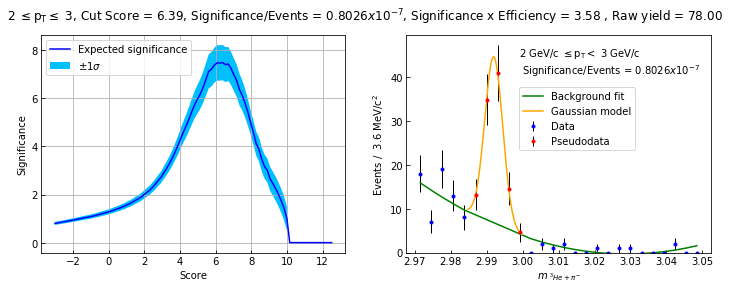

<Figure size 432x288 with 0 Axes>

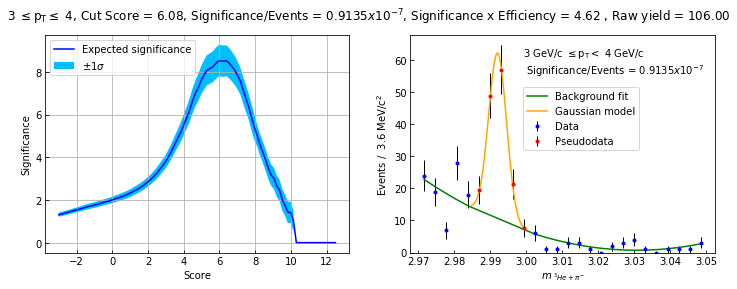

<Figure size 432x288 with 0 Axes>

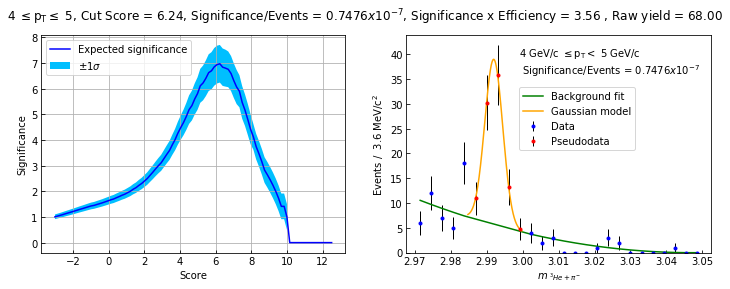

<Figure size 432x288 with 0 Axes>

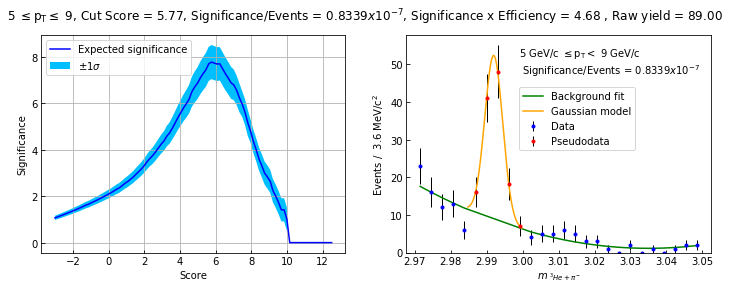

In [58]:
pT_list = [[2,3],[3,4], [4,5],[5,9]]
best_score_list=[]

for i in range(0,4):
    plt.figure();
    dtest = xgb.DMatrix(data=df_18r[training_columns],silent=True)
    df_18r['Score'] = model.predict(dtest,output_margin=True)
    best_score_list.append(SignificanceScan(df_18r,pT_list[i][0],pT_list[i][1],i,efficiency_array,eff_presel,Nev_0_10))
    del dtest

<Figure size 432x288 with 0 Axes>

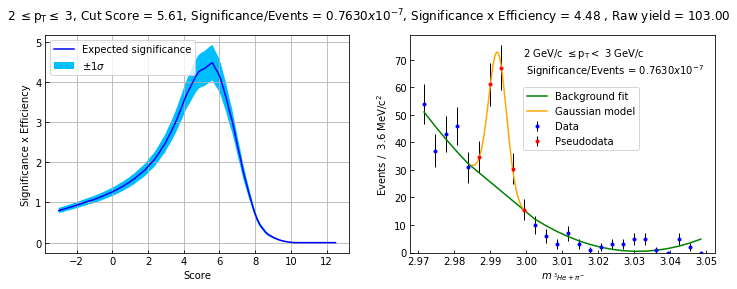

<Figure size 432x288 with 0 Axes>

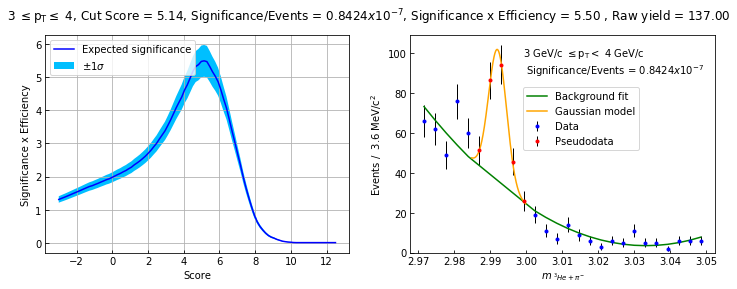

<Figure size 432x288 with 0 Axes>

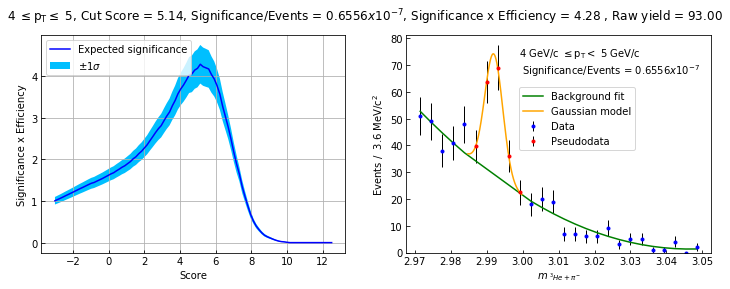

<Figure size 432x288 with 0 Axes>

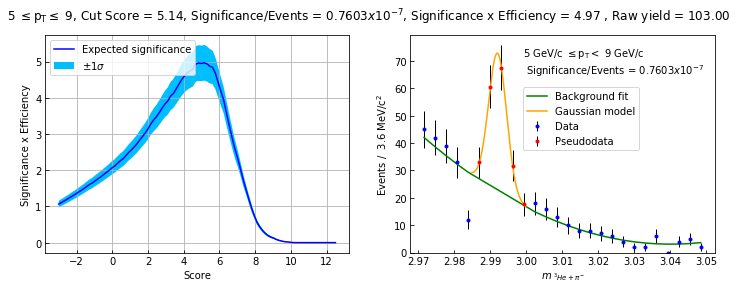

In [59]:
pT_list = [[2,3],[3,4],[4,5],[5,9]]
best_score_list=[]

for i in range(0,4):
    plt.figure();
    dtest = xgb.DMatrix(data=df_18r[training_columns],silent=True)
    df_18r['Score'] = model.predict(dtest,output_margin=True)
    best_score_list.append(SignificanceScan(df_18r,pT_list[i][0],pT_list[i][1],i,efficiency_array,eff_presel,Nev_0_10,True))
    del dtest

#   Test on data

In [38]:
dm=xgb.DMatrix(data=df_18r[training_columns],silent=True)
df_18r['Score']=model.predict(dm,output_margin=True)

Significance/Events =  0.7756095008591606
S/B =  0.5499162023819189
Raw yield =  147.59839263523463


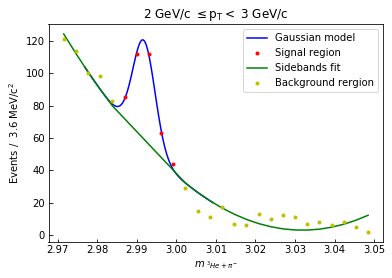

In [50]:
TestOnData(df_18r,5,[2,3],Nev_0_10)

Significance/Events =  1.2592619735717645
S/B =  1.8078187265576022
Raw yield =  214.40260022830626


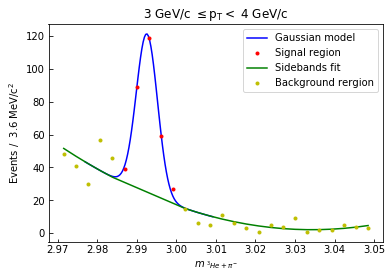

In [40]:
TestOnData(df_18r,5.45,[3,4],Nev_0_10)

Significance/Events =  1.0964107658026379
S/B =  1.156030784906932
Raw yield =  195.1712418263487


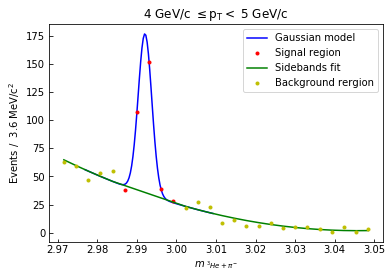

In [51]:
TestOnData(df_18r,5,[4,5],Nev_0_10)

Significance/Events =  1.0300447553795773
S/B =  1.4479088000681515
Raw yield =  156.15284491291095


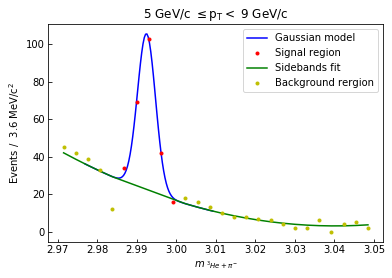

In [60]:
TestOnData(df_18r,5.14,[5,9],Nev_0_10)

# Efficiency Vs Pt

In [ ]:
eff_cuts=[]

In [ ]:
for i in range(0,4):
    index=list(np.linspace(-3,12.5,100)).index(best_score_list[i])
    eff_cuts.append(efficiency_array[index])

In [ ]:
eff_presel=np.array(eff_presel)

In [ ]:
eff_tot=eff_presel*eff_cuts
pt=[2.5,3.5,4.5,7]

In [ ]:
plt.plot(pt,eff_tot,'r.')
plt.xlabel('pt(Gev/c)')
plt.ylabel('Efficiency');